In [1]:
% matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import os
import sys
import random
from glob import glob

from multiprocessing import Pool
import numpy as np
import pandas as pd

from tqdm import tqdm
import scipy.misc
from skimage.morphology import label
import skimage

import warnings
warnings.filterwarnings('ignore')

In [9]:
# Set some parameters
IMG_CHANNELS = 3
DATA = {
    'TRAIN': '../data/train/',
    'TEST': '../data/test/'
}

train_paths = glob(os.path.join(DATA['TRAIN'], '*'))
test_paths = glob(os.path.join(DATA['TEST'], '*'))

MASK_POSTFIX = 'mask_ibn'
seed = 42
P_THRESHOLD = .5
BATCH_SIZE = 16
SIDE = 256
STEP = SIDE // 4

# Amount of categories predicted per pixels.
nb_classes = 1

np.random.seed = seed

SPLIT = .9

In [10]:
def load(path, test_mode=False):
    im = scipy.misc.imread(os.path.join(path, 'images', os.path.basename(path) + '.png'))[..., :IMG_CHANNELS]

    if test_mode:
        return im / 255.
    
    return np.dstack([
        im / 255.,
        np.load(os.path.join(path, MASK_POSTFIX + '.npy')),
    ])

In [11]:
def preprocess_val(patch):
    return np.dstack(
        [
            scipy.ndimage.zoom(
                patch[..., channel],  
                (SIDE / patch.shape[0], SIDE / patch.shape[1])
            ) 
            for channel in range(3)
        ]
        + [scipy.ndimage.zoom(patch[..., -1],  (SIDE / patch.shape[0], SIDE / patch.shape[1]), order=0)]
    )

In [12]:
def preprocess(patch):
    scale = np.random.uniform(.5, 1.1, size=2)
#     if np.random.randint(2):
#         patch = (patch - patch.min((0, 1))) / (patch.max((0, 1)) - patch.min((0, 1)))
    if np.random.randint(2):
        patch = np.flip(patch, 0)
    if np.random.randint(2):
        patch = np.flip(patch, 1)
    if np.random.randint(2):
        patch = np.rot90(patch, k=np.random.randint(3) + 1)
    
    if not np.random.randint(3):
        patch = np.concatenate([np.flip(patch, 0), patch, np.flip(patch, 0)])
    if not np.random.randint(3):
        patch = np.concatenate([np.flip(patch, 1), patch, np.flip(patch, 1)], 1)
    
#     if np.random.randint(4):
#         rotate = np.random.uniform(-40, 40)
#         patch = np.dstack([
#             scipy.ndimage.rotate(patch[..., 0], rotate),
#             scipy.ndimage.rotate(patch[..., -1:], rotate, order=0)
#         ])
#         patch = skimage.transform.rotate(patch, rotate, mode='constant', preserve_range=True)
    
    window = np.clip(SIDE * scale, 0, min(patch.shape[:-1]))
    if np.count_nonzero(patch[..., -1]):
        coords = np.array(np.where(patch[..., -1]))
        cmin, cmax = coords.min(1) - window, coords.max(1)
        point = np.array([
            np.random.randint(cmin[0], cmax[0]),
            np.random.randint(cmin[1], cmax[1])
        ])
    else:
        point = np.array([
            np.random.randint(0, patch.shape[0] - window[0] + 1),
            np.random.randint(0, patch.shape[1] - window[1] + 1)
        ]) 
    point = np.clip(point, 0, np.array(patch.shape[:-1]) - window).astype(np.int)

    patch = patch[
        point[0]: point[0] + int(window[0]), 
        point[1]: point[1] + int(window[1])
    ]
    
    return np.dstack(
        [scipy.ndimage.zoom(
            patch[..., channel],  
            (SIDE / patch.shape[0], SIDE / patch.shape[1])
        ) 
         for channel in range(3)]
        + [scipy.ndimage.zoom(patch[..., -1],  (SIDE / patch.shape[0], SIDE / patch.shape[1]), order=0)]
    )

In [13]:
def generator(paths, preprocess, batch_size=BATCH_SIZE, train_mode=False):
    while True:
        if train_mode:
            np.random.shuffle(paths)
            
        for i in range(len(paths) // batch_size + 1):
#             with Pool(4) as pool:
#                 processed = pool.map(load, batch)
#             with Pool(4) as pool:
#                 processed = pool.map(preprocess, processed)
            batch = paths[i * batch_size: (i + 1) * batch_size]
            processed = np.zeros((batch_size, SIDE, SIDE, 4))
            for j, path in enumerate(batch):
                im = load(path)
                processed[j] = preprocess(im)

            yield processed[..., :-1], np.expand_dims(processed[..., -1], -1)

In [14]:
train_gen = generator(train_paths, preprocess, batch_size=BATCH_SIZE, train_mode=False)
a = next(train_gen)

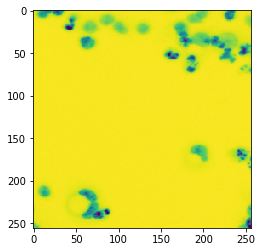

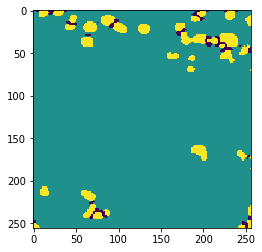

In [15]:
i = 3
plt.imshow(np.abs(a[0][i,...,1] - 1))
plt.show()
plt.imshow(a[1][i, ...,0])

In [16]:
from keras import backend as K


K.set_image_data_format('channels_last')  # TF dimension ordering in this code

# 
# 
smooth = 1.
# 
# 

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(K.cast(K.greater(y_true_f, 0), 'float32')) + K.sum(y_pred_f) + smooth)


def binary_crossentropy(target, output, from_logits=False):
    """Binary crossentropy between an output tensor and a target tensor.
    # Arguments
        target: A tensor with the same shape as `output`.
        output: A tensor.
        from_logits: Whether `output` is expected to be a logits tensor.
            By default, we consider that `output`
            encodes a probability distribution.
    # Returns
        A tensor.
    """
    # Note: tf.nn.sigmoid_cross_entropy_with_logits
    # expects logits, Keras expects probabilities.
    if not from_logits:
        # transform back to logits
        _epsilon = K._to_tensor(epsilon(), output.dtype.base_dtype)
        output = tf.clip_by_value(output, _epsilon, 1 - _epsilon)
        output = tf.log(output / (1 - output))

    return tf.nn.sigmoid_cross_entropy_with_logits(
        labels=target,
        logits=output
    )


def binary_crossentropy(y_true, y_pred):
    return K.mean(K.binary_crossentropy(K.cast(K.greater(y_true, 0), 'float32'), y_pred))

def dice_coef_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + 1 - dice_coef(y_true, y_pred)

# def dice_coef_loss(y_true, y_pred):
#     return binary_crossentropy(y_true, y_pred) - K.log(dice_coef(y_true, y_pred))
#     return -dice_coef(y_true, y_pred)

Using TensorFlow backend.


In [17]:
# for n, path in tqdm(enumerate(train_paths), total=len(train_paths)):
#     masks = list()
#     nucleus_frontier = list()
#     for mask_file in next(os.walk(path + '/masks/'))[2]:
#         im = scipy.misc.imread(path + '/masks/' + mask_file) > 0
#         masks.append(im)
#         nucleus_frontier.append(im & np.logical_not(scipy.ndimage.binary_erosion(im)))

#     mask = np.array(masks).max(0)
#     nucleus_frontier = np.array(nucleus_frontier).max(0)

#     imask = mask.copy().astype(np.float)
#     borders = np.zeros(np.array(imask.shape) - 4, dtype=np.bool_)
#     borders = np.pad(borders, pad_width=2, mode='constant', constant_values=1)

#     allowed_area = np.logical_not(mask) | nucleus_frontier

#     for im in masks:
#         tmp = mask.copy()
        
#         tmp_borders = borders.copy()
#         tmp[im] = False
#         tmp_borders[im] = False
        
#         dilated_im = scipy.ndimage.binary_dilation(im, iterations=3)
#         intersection = (
#             (scipy.ndimage.binary_dilation(tmp, iterations=3) & dilated_im & allowed_area) |
#             (tmp_borders & dilated_im)
#         )
#         imask[intersection] = -1.
#     np.save(path + '/mask_ibn', imask)


sizes_train = dict()
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, path in tqdm(enumerate(train_paths), total=len(train_paths)):
    img = scipy.misc.imread(os.path.join(path, 'images', os.path.basename(path) + '.png'))[..., :IMG_CHANNELS]
    sizes_train[path] = ([img.shape[0], img.shape[1]])
    

sizes_test = dict()
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, path in tqdm(enumerate(test_paths), total=len(test_paths)):
    img = scipy.misc.imread(os.path.join(path, 'images', os.path.basename(path) + '.png'))[..., :IMG_CHANNELS]
    sizes_test[path] = ([img.shape[0], img.shape[1]])

Getting and resizing test images ... 


100%|██████████| 670/670 [00:02<00:00, 231.52it/s]

Getting and resizing test images ... 



100%|██████████| 65/65 [00:00<00:00, 182.52it/s]


In [18]:
import pickle

# pickle.dump(std_paths, open('../data/test_std_paths.pkl', 'wb'))
std_paths = pickle.load(open('../data/std_paths.pkl', 'rb'))
test_std_paths = pickle.load(open('../data/test_std_paths.pkl', 'rb'))

In [19]:
paths = [path[0] for path in std_paths]
rs = np.random.RandomState(seed=12)
rs.shuffle(paths)

In [20]:
import sys
sys.path.append('..')
from models import UNet
from models import elu_UNet


model = elu_UNet.get_unet((SIDE, SIDE, 3), 16, optimizer='adam', #sgd(nesterov=True, momentum=.9, decay=1e-5)
                          loss=dice_coef_loss, metrics=[binary_crossentropy, dice_coef])

In [21]:
def inverse_rle(rle):
    rle_ = list(map(int, rle.split(' ')))
    inv = list()
    for idx in range(len(rle_) // 2):
        inv.extend(list(range(rle_[2 * idx], rle_[2 * idx] + rle_[2 * idx + 1])))
    return inv

from skimage.morphology import closing, opening, disk
def clean_img(x):
    return opening(closing(x, disk(1)), disk(3))

In [22]:
# Run-length encoding stolen from https://www.kaggle.com/rakhlin/fast-run-length-encoding-python
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b > prev + 1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cutoff=.5):
    lab_img = label(x > cutoff)
#     lab_img_dilated2 = label(scipy.ndimage.binary_dilation(x > cutoff, iterations=2))
#     lab_img_dilated1 = label(scipy.ndimage.binary_dilation(x > cutoff, iterations=1))
    for colour in range(1, lab_img.max() + 1):
#         inter = lab_img[lab_img_dilated2 == lab_img_dilated2[lab_img == colour][0]]
#         inter = inter[inter != 0]
#         if len(np.unique(inter)) == 1:
#             yield rle_encoding(scipy.ndimage.binary_dilation(lab_img == colour, iterations=2))
#             continue
#         inter = lab_img[lab_img_dilated1 == lab_img_dilated1[lab_img == colour][0]]
#         inter = inter[inter != 0]
#         if len(np.unique(inter)) == 1:
#             yield rle_encoding(scipy.ndimage.binary_dilation(lab_img == colour, iterations=1))
#             continue
        yield rle_encoding(lab_img == colour)

In [23]:
MODEL_PREFIX = 'Telu32_channels3_bce1dice_unet_border1_dilated3_val_'

In [24]:
def preprocess_test(patch):
    return np.dstack([
        scipy.ndimage.zoom(
            patch[..., channel],  
            (SIDE / patch.shape[0], SIDE / patch.shape[1])
        ) 
        for channel in range(3)
    ])


def generator_test(paths, batch_size=BATCH_SIZE, train_mode=False):
    while True:
        if train_mode:
            np.random.shuffle(paths)
            
        for i in range(len(paths) // batch_size + 1):
            batch = paths[i * batch_size: (i + 1) * batch_size]
#             with Pool(4) as pool:
#                 processed = pool.map(load, batch)
            processed = np.zeros((batch_size, SIDE, SIDE, 3))
            for j, path in enumerate(batch):
                im = load(path, test_mode=True)
                processed[j] = preprocess_test(im)

            yield processed

In [25]:
model = UNet.get_unet((SIDE, SIDE, 3), filters_init=32, optimizer='adam', #sgd(nesterov=True, momentum=.9, decay=1e-5)
                        loss=dice_coef_loss, metrics=[binary_crossentropy, dice_coef], activation='elu')


In [44]:
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras.optimizers import sgd


inter = len(paths) - int(SPLIT * len(paths))
val_evals = list()
for i in range(10):
    train_paths = paths[:i * inter] + paths[(i + 1) * inter:]
    val_paths = paths[i * inter: (i + 1) * inter]

    test_paths = [path[0] for path in test_std_paths]

    callbacks = [
        TensorBoard(log_dir='../data/logs'),
        ModelCheckpoint(
            verbose=True,
            filepath='../data/' + MODEL_PREFIX + str(i),
            save_best_only=True
        )
    ]

    train_gen = generator(train_paths, preprocess, batch_size=BATCH_SIZE, train_mode=True)
    val_gen = generator(val_paths, preprocess_val, batch_size=BATCH_SIZE, train_mode=False)

#     model = elu_UNet.get_unet((SIDE, SIDE, 3), filters_init=16, optimizer='adam', #sgd(nesterov=True, momentum=.9, decay=1e-5)
#                               loss=dice_coef_loss, metrics=[binary_crossentropy, dice_coef])
    model = UNet.get_unet((SIDE, SIDE, 3), filters_init=32, optimizer='adam', #sgd(nesterov=True, momentum=.9, decay=1e-5)
                        loss=dice_coef_loss, metrics=[binary_crossentropy, dice_coef], activation='elu')

    model.fit_generator(
        generator=train_gen,
        steps_per_epoch=max(len(train_paths) // BATCH_SIZE + 1, 10), 
        epochs=100, 
        callbacks=callbacks, 
        validation_data=val_gen, 
        validation_steps=len(val_paths) // BATCH_SIZE + 1, 
    )
    
    model.load_weights(os.path.join('..', 'data', MODEL_PREFIX + str(i)))
    
    val_paths = paths[i * inter: (i + 1) * inter]
    val_gen = generator_test(val_paths, batch_size=1, train_mode=False)
    val = [next(val_gen) for i in range(len(val_paths))]
    val = np.concatenate(val, 0)
    val = val[:len(val_paths)]

    p = model.predict(val)
    p1 = model.predict(np.flip(val, 1))
    p2 = model.predict(np.flip(val, 2))
    p3 = model.predict(np.flip(np.flip(val, 1), 2))

    pred = (
        np.mean(
            np.stack([
                p, 
                np.flip(p1, 1), 
                np.flip(p2, 2), 
                np.flip(np.flip(p3, 1), 2)
            ], -1), 
            -1
        )
    )

    # Create list of upsampled test masks
    preds_val_upsampled = list()
    for v_idx in range(len(pred)):
        preds_val_upsampled.append(
            skimage.transform.resize(
                np.squeeze(pred[v_idx]), 
                sizes_train[val_paths[v_idx]],
                mode='constant', 
                preserve_range=True
            )
        )


    new_val_ids = []
    rles = []
    for n, path in tqdm(enumerate(val_paths)):
        rle = list(prob_to_rles(preds_val_upsampled[n], cutoff=P_THRESHOLD))
        rles.extend(rle)
        new_val_ids.extend([os.path.basename(path)] * len(rle))


    val_df = pd.DataFrame()
    val_df['ImageId'] = new_val_ids
    val_df['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
    val_ids = pd.Series(val_paths).apply(lambda x: os.path.basename(x))
    val_eval = pd.DataFrame(val_ids, columns=['ImageId'])


    train_labels = pd.read_csv('../data/stage1_train_labels.csv')
    tl_rles = train_labels[train_labels.ImageId.isin(val_ids)]

    for t in np.arange(.5, 1, .05):
        val_eval["%.2f"%t] = 0.

    for vidx in tqdm(val_ids.index):
        for t in np.arange(.5, 1, .05):
            gtrue_rles = tl_rles.query('ImageId=="{ImageId}"'.format(ImageId=val_ids[vidx]))['EncodedPixels']
            pred_rles = val_df.query('ImageId=="{ImageId}"'.format(ImageId=val_ids[vidx]))['EncodedPixels']
            pred_rles = pred_rles.values.tolist()
            FN = np.ones_like(gtrue_rles)
            TP = 0

            for gidx, gtrue_ in enumerate(gtrue_rles):
                gtrue_ = set(inverse_rle(gtrue_))
                for idx, pred_ in enumerate(pred_rles):
                    pred_ = set(inverse_rle(pred_))
                    IoU = len(pred_.intersection(gtrue_)) / len(pred_.union(gtrue_))
                    if IoU > t:
                        TP += 1
                        pred_rles.pop(idx)
                        FN[gidx] = 0
                        continue

            val_eval.loc[val_eval.ImageId == val_ids[vidx], "%.2f"%t] = TP / (TP + len(pred_rles) + FN.sum())

    val_eval['tmean'] = val_eval[["%.2f"%t for t in np.arange(.5, 1, .05)]].mean(1)
    print(val_eval.tmean.mean())
    print(val_eval[["%.2f"%t for t in np.arange(.5, 1, .05)]].mean())
    val_evals.append(val_eval)

    model.save_weights('../data/' + MODEL_PREFIX + str(i) + '_score_' + "%.3f" % val_eval.tmean.mean())

Epoch 1/100
37/38 [============================>.] - ETA: 0s - loss: 1.2259 - binary_crossentropy: 0.4453 - dice_coef: 0.2194
Epoch 00001: val_loss improved from inf to 1.13763, saving model to ../data/Telu32_channels3_bce1dice_unet_border1_dilated3_val_0
38/38 [==============================] - 23s 599ms/step - loss: 1.2232 - binary_crossentropy: 0.4435 - dice_coef: 0.2204 - val_loss: 1.1376 - val_binary_crossentropy: 0.3674 - val_dice_coef: 0.2298
Epoch 2/100
37/38 [============================>.] - ETA: 0s - loss: 1.1139 - binary_crossentropy: 0.3737 - dice_coef: 0.2598
Epoch 00002: val_loss improved from 1.13763 to 0.90140, saving model to ../data/Telu32_channels3_bce1dice_unet_border1_dilated3_val_0
38/38 [==============================] - 22s 570ms/step - loss: 1.1063 - binary_crossentropy: 0.3679 - dice_coef: 0.2616 - val_loss: 0.9014 - val_binary_crossentropy: 0.2377 - val_dice_coef: 0.3363
Epoch 3/100
37/38 [============================>.] - ETA: 0s - loss: 0.6724 - binary_cro

Epoch 21/100
37/38 [============================>.] - ETA: 0s - loss: 0.2914 - binary_crossentropy: 0.1120 - dice_coef: 0.8206
Epoch 00021: val_loss improved from 0.25977 to 0.24942, saving model to ../data/Telu32_channels3_bce1dice_unet_border1_dilated3_val_0
38/38 [==============================] - 22s 573ms/step - loss: 0.2896 - binary_crossentropy: 0.1109 - dice_coef: 0.8213 - val_loss: 0.2494 - val_binary_crossentropy: 0.0896 - val_dice_coef: 0.8402
Epoch 22/100
37/38 [============================>.] - ETA: 0s - loss: 0.3059 - binary_crossentropy: 0.1189 - dice_coef: 0.8130
Epoch 00022: val_loss did not improve
38/38 [==============================] - 22s 579ms/step - loss: 0.3066 - binary_crossentropy: 0.1191 - dice_coef: 0.8125 - val_loss: 0.2720 - val_binary_crossentropy: 0.0993 - val_dice_coef: 0.8273
Epoch 23/100
37/38 [============================>.] - ETA: 0s - loss: 0.2996 - binary_crossentropy: 0.1184 - dice_coef: 0.8189
Epoch 00023: val_loss did not improve
38/38 [======

37/38 [============================>.] - ETA: 0s - loss: 0.2451 - binary_crossentropy: 0.0949 - dice_coef: 0.8498
Epoch 00042: val_loss did not improve
38/38 [==============================] - 22s 570ms/step - loss: 0.2415 - binary_crossentropy: 0.0930 - dice_coef: 0.8515 - val_loss: 0.2291 - val_binary_crossentropy: 0.0768 - val_dice_coef: 0.8478
Epoch 43/100
37/38 [============================>.] - ETA: 0s - loss: 0.2361 - binary_crossentropy: 0.0911 - dice_coef: 0.8551
Epoch 00043: val_loss improved from 0.22555 to 0.21835, saving model to ../data/Telu32_channels3_bce1dice_unet_border1_dilated3_val_0
38/38 [==============================] - 22s 575ms/step - loss: 0.2340 - binary_crossentropy: 0.0901 - dice_coef: 0.8561 - val_loss: 0.2183 - val_binary_crossentropy: 0.0756 - val_dice_coef: 0.8573
Epoch 44/100
37/38 [============================>.] - ETA: 0s - loss: 0.2358 - binary_crossentropy: 0.0898 - dice_coef: 0.8540
Epoch 00044: val_loss did not improve
38/38 [===================

Epoch 64/100
37/38 [============================>.] - ETA: 0s - loss: 0.2222 - binary_crossentropy: 0.0849 - dice_coef: 0.8627
Epoch 00064: val_loss improved from 0.21172 to 0.21017, saving model to ../data/Telu32_channels3_bce1dice_unet_border1_dilated3_val_0
38/38 [==============================] - 23s 597ms/step - loss: 0.2209 - binary_crossentropy: 0.0844 - dice_coef: 0.8635 - val_loss: 0.2102 - val_binary_crossentropy: 0.0719 - val_dice_coef: 0.8617
Epoch 65/100
37/38 [============================>.] - ETA: 0s - loss: 0.2203 - binary_crossentropy: 0.0829 - dice_coef: 0.8626
Epoch 00065: val_loss improved from 0.21017 to 0.21013, saving model to ../data/Telu32_channels3_bce1dice_unet_border1_dilated3_val_0
38/38 [==============================] - 23s 594ms/step - loss: 0.2204 - binary_crossentropy: 0.0822 - dice_coef: 0.8618 - val_loss: 0.2101 - val_binary_crossentropy: 0.0716 - val_dice_coef: 0.8615
Epoch 66/100
37/38 [============================>.] - ETA: 0s - loss: 0.2222 - bin

Epoch 86/100
37/38 [============================>.] - ETA: 0s - loss: 0.2174 - binary_crossentropy: 0.0837 - dice_coef: 0.8663
Epoch 00086: val_loss did not improve
38/38 [==============================] - 22s 575ms/step - loss: 0.2165 - binary_crossentropy: 0.0830 - dice_coef: 0.8666 - val_loss: 0.2136 - val_binary_crossentropy: 0.0722 - val_dice_coef: 0.8586
Epoch 87/100
37/38 [============================>.] - ETA: 0s - loss: 0.2193 - binary_crossentropy: 0.0836 - dice_coef: 0.8643
Epoch 00087: val_loss did not improve
38/38 [==============================] - 22s 568ms/step - loss: 0.2182 - binary_crossentropy: 0.0827 - dice_coef: 0.8645 - val_loss: 0.2129 - val_binary_crossentropy: 0.0768 - val_dice_coef: 0.8638
Epoch 88/100
37/38 [============================>.] - ETA: 0s - loss: 0.2207 - binary_crossentropy: 0.0834 - dice_coef: 0.8627
Epoch 00088: val_loss did not improve
38/38 [==============================] - 22s 590ms/step - loss: 0.2202 - binary_crossentropy: 0.0827 - dice_c

67it [00:00, 87.91it/s]
100%|██████████| 67/67 [00:56<00:00,  1.19it/s]


0.44967535465066333
0.50    0.633797
0.55    0.603567
0.60    0.575958
0.65    0.540596
0.70    0.518145
0.75    0.483795
0.80    0.427267
0.85    0.351232
0.90    0.251690
0.95    0.110705
dtype: float64
Epoch 1/100
37/38 [============================>.] - ETA: 0s - loss: 1.2482 - binary_crossentropy: 0.4483 - dice_coef: 0.2001
Epoch 00001: val_loss improved from inf to 1.07968, saving model to ../data/Telu32_channels3_bce1dice_unet_border1_dilated3_val_1
38/38 [==============================] - 24s 624ms/step - loss: 1.2374 - binary_crossentropy: 0.4412 - dice_coef: 0.2038 - val_loss: 1.0797 - val_binary_crossentropy: 0.3896 - val_dice_coef: 0.3100
Epoch 2/100
37/38 [============================>.] - ETA: 0s - loss: 0.7547 - binary_crossentropy: 0.2998 - dice_coef: 0.5451
Epoch 00002: val_loss improved from 1.07968 to 0.55719, saving model to ../data/Telu32_channels3_bce1dice_unet_border1_dilated3_val_1
38/38 [==============================] - 21s 553ms/step - loss: 0.7522 - binary_c

37/38 [============================>.] - ETA: 0s - loss: 0.2721 - binary_crossentropy: 0.1089 - dice_coef: 0.8368
Epoch 00020: val_loss did not improve
38/38 [==============================] - 21s 566ms/step - loss: 0.2714 - binary_crossentropy: 0.1088 - dice_coef: 0.8374 - val_loss: 0.2953 - val_binary_crossentropy: 0.1038 - val_dice_coef: 0.8085
Epoch 21/100
37/38 [============================>.] - ETA: 0s - loss: 0.2564 - binary_crossentropy: 0.1020 - dice_coef: 0.8456
Epoch 00021: val_loss did not improve
38/38 [==============================] - 21s 564ms/step - loss: 0.2539 - binary_crossentropy: 0.1007 - dice_coef: 0.8468 - val_loss: 0.2699 - val_binary_crossentropy: 0.0911 - val_dice_coef: 0.8213
Epoch 22/100
37/38 [============================>.] - ETA: 0s - loss: 0.2504 - binary_crossentropy: 0.0989 - dice_coef: 0.8485
Epoch 00022: val_loss did not improve
38/38 [==============================] - 21s 556ms/step - loss: 0.2494 - binary_crossentropy: 0.0978 - dice_coef: 0.8484 -

Epoch 42/100
37/38 [============================>.] - ETA: 0s - loss: 0.2098 - binary_crossentropy: 0.0795 - dice_coef: 0.8697
Epoch 00042: val_loss did not improve
38/38 [==============================] - 21s 546ms/step - loss: 0.2116 - binary_crossentropy: 0.0802 - dice_coef: 0.8685 - val_loss: 0.2356 - val_binary_crossentropy: 0.0782 - val_dice_coef: 0.8427
Epoch 43/100
37/38 [============================>.] - ETA: 0s - loss: 0.2238 - binary_crossentropy: 0.0869 - dice_coef: 0.8631
Epoch 00043: val_loss did not improve
38/38 [==============================] - 21s 559ms/step - loss: 0.2222 - binary_crossentropy: 0.0857 - dice_coef: 0.8636 - val_loss: 0.2423 - val_binary_crossentropy: 0.0774 - val_dice_coef: 0.8350
Epoch 44/100
37/38 [============================>.] - ETA: 0s - loss: 0.2130 - binary_crossentropy: 0.0803 - dice_coef: 0.8673
Epoch 00044: val_loss did not improve
38/38 [==============================] - 21s 549ms/step - loss: 0.2120 - binary_crossentropy: 0.0797 - dice_c

37/38 [============================>.] - ETA: 0s - loss: 0.2113 - binary_crossentropy: 0.0820 - dice_coef: 0.8707
Epoch 00064: val_loss did not improve
38/38 [==============================] - 22s 569ms/step - loss: 0.2119 - binary_crossentropy: 0.0815 - dice_coef: 0.8695 - val_loss: 0.2240 - val_binary_crossentropy: 0.0701 - val_dice_coef: 0.8461
Epoch 65/100
37/38 [============================>.] - ETA: 0s - loss: 0.2023 - binary_crossentropy: 0.0765 - dice_coef: 0.8742
Epoch 00065: val_loss did not improve
38/38 [==============================] - 21s 562ms/step - loss: 0.2019 - binary_crossentropy: 0.0759 - dice_coef: 0.8740 - val_loss: 0.2291 - val_binary_crossentropy: 0.0788 - val_dice_coef: 0.8497
Epoch 66/100
37/38 [============================>.] - ETA: 0s - loss: 0.1993 - binary_crossentropy: 0.0750 - dice_coef: 0.8757
Epoch 00066: val_loss did not improve
38/38 [==============================] - 21s 558ms/step - loss: 0.1968 - binary_crossentropy: 0.0735 - dice_coef: 0.8767 -

37/38 [============================>.] - ETA: 0s - loss: 0.2056 - binary_crossentropy: 0.0782 - dice_coef: 0.8726
Epoch 00086: val_loss improved from 0.21479 to 0.21404, saving model to ../data/Telu32_channels3_bce1dice_unet_border1_dilated3_val_1
38/38 [==============================] - 21s 551ms/step - loss: 0.2042 - binary_crossentropy: 0.0772 - dice_coef: 0.8730 - val_loss: 0.2140 - val_binary_crossentropy: 0.0716 - val_dice_coef: 0.8575
Epoch 87/100
37/38 [============================>.] - ETA: 0s - loss: 0.1985 - binary_crossentropy: 0.0762 - dice_coef: 0.8777
Epoch 00087: val_loss did not improve
38/38 [==============================] - 21s 561ms/step - loss: 0.1991 - binary_crossentropy: 0.0758 - dice_coef: 0.8768 - val_loss: 0.2255 - val_binary_crossentropy: 0.0780 - val_dice_coef: 0.8525
Epoch 88/100
37/38 [============================>.] - ETA: 0s - loss: 0.2033 - binary_crossentropy: 0.0778 - dice_coef: 0.8744
Epoch 00088: val_loss did not improve
38/38 [===================

67it [00:01, 44.12it/s]
100%|██████████| 67/67 [02:42<00:00,  2.43s/it]


0.4699765832374069
0.50    0.667959
0.55    0.651048
0.60    0.627701
0.65    0.592860
0.70    0.554524
0.75    0.506720
0.80    0.437674
0.85    0.341774
0.90    0.226706
0.95    0.092800
dtype: float64
Epoch 1/100
37/38 [============================>.] - ETA: 0s - loss: 1.1069 - binary_crossentropy: 0.4498 - dice_coef: 0.3428
Epoch 00001: val_loss improved from inf to 0.75947, saving model to ../data/Telu32_channels3_bce1dice_unet_border1_dilated3_val_2
38/38 [==============================] - 23s 611ms/step - loss: 1.0893 - binary_crossentropy: 0.4401 - dice_coef: 0.3508 - val_loss: 0.7595 - val_binary_crossentropy: 0.3217 - val_dice_coef: 0.5622
Epoch 2/100
37/38 [============================>.] - ETA: 0s - loss: 0.5703 - binary_crossentropy: 0.2207 - dice_coef: 0.6504
Epoch 00002: val_loss improved from 0.75947 to 0.45452, saving model to ../data/Telu32_channels3_bce1dice_unet_border1_dilated3_val_2
38/38 [==============================] - 20s 527ms/step - loss: 0.5691 - binary_cr

Epoch 20/100
37/38 [============================>.] - ETA: 0s - loss: 0.2569 - binary_crossentropy: 0.0998 - dice_coef: 0.8429
Epoch 00020: val_loss did not improve
38/38 [==============================] - 23s 594ms/step - loss: 0.2544 - binary_crossentropy: 0.0986 - dice_coef: 0.8441 - val_loss: 0.2396 - val_binary_crossentropy: 0.0845 - val_dice_coef: 0.8449
Epoch 21/100
37/38 [============================>.] - ETA: 0s - loss: 0.2500 - binary_crossentropy: 0.0989 - dice_coef: 0.8489
Epoch 00021: val_loss did not improve
38/38 [==============================] - 21s 558ms/step - loss: 0.2481 - binary_crossentropy: 0.0976 - dice_coef: 0.8495 - val_loss: 0.2288 - val_binary_crossentropy: 0.0725 - val_dice_coef: 0.8436
Epoch 22/100
37/38 [============================>.] - ETA: 0s - loss: 0.2423 - binary_crossentropy: 0.0931 - dice_coef: 0.8508
Epoch 00022: val_loss did not improve
38/38 [==============================] - 22s 587ms/step - loss: 0.2437 - binary_crossentropy: 0.0926 - dice_c

Epoch 47/100
37/38 [============================>.] - ETA: 0s - loss: 0.2254 - binary_crossentropy: 0.0860 - dice_coef: 0.8606
Epoch 00047: val_loss did not improve
38/38 [==============================] - 21s 564ms/step - loss: 0.2256 - binary_crossentropy: 0.0851 - dice_coef: 0.8596 - val_loss: 0.2099 - val_binary_crossentropy: 0.0670 - val_dice_coef: 0.8570
Epoch 48/100
37/38 [============================>.] - ETA: 0s - loss: 0.2209 - binary_crossentropy: 0.0849 - dice_coef: 0.8640
Epoch 00048: val_loss did not improve
38/38 [==============================] - 21s 559ms/step - loss: 0.2203 - binary_crossentropy: 0.0840 - dice_coef: 0.8637 - val_loss: 0.2053 - val_binary_crossentropy: 0.0677 - val_dice_coef: 0.8624
Epoch 49/100
37/38 [============================>.] - ETA: 0s - loss: 0.2206 - binary_crossentropy: 0.0835 - dice_coef: 0.8629
Epoch 00049: val_loss did not improve
38/38 [==============================] - 20s 537ms/step - loss: 0.2211 - binary_crossentropy: 0.0836 - dice_c

37/38 [============================>.] - ETA: 0s - loss: 0.2172 - binary_crossentropy: 0.0837 - dice_coef: 0.8665
Epoch 00069: val_loss improved from 0.19818 to 0.19616, saving model to ../data/Telu32_channels3_bce1dice_unet_border1_dilated3_val_2
38/38 [==============================] - 21s 553ms/step - loss: 0.2160 - binary_crossentropy: 0.0821 - dice_coef: 0.8662 - val_loss: 0.1962 - val_binary_crossentropy: 0.0613 - val_dice_coef: 0.8651
Epoch 70/100
37/38 [============================>.] - ETA: 0s - loss: 0.2083 - binary_crossentropy: 0.0792 - dice_coef: 0.8709
Epoch 00070: val_loss did not improve
38/38 [==============================] - 21s 563ms/step - loss: 0.2056 - binary_crossentropy: 0.0777 - dice_coef: 0.8721 - val_loss: 0.1996 - val_binary_crossentropy: 0.0647 - val_dice_coef: 0.8651
Epoch 71/100
37/38 [============================>.] - ETA: 0s - loss: 0.2075 - binary_crossentropy: 0.0788 - dice_coef: 0.8712
Epoch 00071: val_loss did not improve
38/38 [===================

37/38 [============================>.] - ETA: 0s - loss: 0.1982 - binary_crossentropy: 0.0755 - dice_coef: 0.8773
Epoch 00091: val_loss did not improve
38/38 [==============================] - 21s 555ms/step - loss: 0.1976 - binary_crossentropy: 0.0747 - dice_coef: 0.8771 - val_loss: 0.2001 - val_binary_crossentropy: 0.0654 - val_dice_coef: 0.8653
Epoch 92/100
37/38 [============================>.] - ETA: 0s - loss: 0.1995 - binary_crossentropy: 0.0742 - dice_coef: 0.8747
Epoch 00092: val_loss did not improve
38/38 [==============================] - 23s 600ms/step - loss: 0.1968 - binary_crossentropy: 0.0730 - dice_coef: 0.8762 - val_loss: 0.1951 - val_binary_crossentropy: 0.0648 - val_dice_coef: 0.8698
Epoch 93/100
37/38 [============================>.] - ETA: 0s - loss: 0.2100 - binary_crossentropy: 0.0788 - dice_coef: 0.8688
Epoch 00093: val_loss did not improve
38/38 [==============================] - 21s 563ms/step - loss: 0.2095 - binary_crossentropy: 0.0782 - dice_coef: 0.8687 -

67it [00:01, 51.63it/s]
100%|██████████| 67/67 [01:16<00:00,  1.14s/it]


0.5305616819567056
0.50    0.741683
0.55    0.709419
0.60    0.690041
0.65    0.645243
0.70    0.609580
0.75    0.562916
0.80    0.513586
0.85    0.436680
0.90    0.305230
0.95    0.091240
dtype: float64
Epoch 1/100
37/38 [============================>.] - ETA: 0s - loss: 1.2230 - binary_crossentropy: 0.4940 - dice_coef: 0.2711
Epoch 00001: val_loss improved from inf to 0.73564, saving model to ../data/Telu32_channels3_bce1dice_unet_border1_dilated3_val_3
38/38 [==============================] - 25s 645ms/step - loss: 1.2050 - binary_crossentropy: 0.4847 - dice_coef: 0.2796 - val_loss: 0.7356 - val_binary_crossentropy: 0.2627 - val_dice_coef: 0.5271
Epoch 2/100
37/38 [============================>.] - ETA: 0s - loss: 0.7215 - binary_crossentropy: 0.2855 - dice_coef: 0.5640
Epoch 00002: val_loss improved from 0.73564 to 0.56507, saving model to ../data/Telu32_channels3_bce1dice_unet_border1_dilated3_val_3
38/38 [==============================] - 20s 535ms/step - loss: 0.7206 - binary_cr

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



37/38 [============================>.] - ETA: 0s - loss: 0.2238 - binary_crossentropy: 0.0850 - dice_coef: 0.8612
Epoch 00069: val_loss did not improve
38/38 [==============================] - 22s 571ms/step - loss: 0.2234 - binary_crossentropy: 0.0843 - dice_coef: 0.8609 - val_loss: 0.2076 - val_binary_crossentropy: 0.0630 - val_dice_coef: 0.8553
Epoch 70/100
37/38 [============================>.] - ETA: 0s - loss: 0.2308 - binary_crossentropy: 0.0897 - dice_coef: 0.8589
Epoch 00070: val_loss did not improve
38/38 [==============================] - 20s 538ms/step - loss: 0.2302 - binary_crossentropy: 0.0891 - dice_coef: 0.8590 - val_loss: 0.2091 - val_binary_crossentropy: 0.0628 - val_dice_coef: 0.8538
Epoch 71/100
37/38 [============================>.] - ETA: 0s - loss: 0.2230 - binary_crossentropy: 0.0840 - dice_coef: 0.8609
Epoch 00071: val_loss did not improve
38/38 [==============================] - 23s 597ms/step - loss: 0.2220 - binary_crossentropy: 0.0832 - dice_coef: 0.8612 -

37/38 [============================>.] - ETA: 0s - loss: 0.2143 - binary_crossentropy: 0.0815 - dice_coef: 0.8672
Epoch 00091: val_loss improved from 0.20266 to 0.19746, saving model to ../data/Telu32_channels3_bce1dice_unet_border1_dilated3_val_3
38/38 [==============================] - 22s 570ms/step - loss: 0.2148 - binary_crossentropy: 0.0813 - dice_coef: 0.8665 - val_loss: 0.1975 - val_binary_crossentropy: 0.0589 - val_dice_coef: 0.8614
Epoch 92/100
37/38 [============================>.] - ETA: 0s - loss: 0.2172 - binary_crossentropy: 0.0832 - dice_coef: 0.8660
Epoch 00092: val_loss did not improve
38/38 [==============================] - 21s 550ms/step - loss: 0.2175 - binary_crossentropy: 0.0835 - dice_coef: 0.8660 - val_loss: 0.2031 - val_binary_crossentropy: 0.0585 - val_dice_coef: 0.8554
Epoch 93/100
37/38 [============================>.] - ETA: 0s - loss: 0.2213 - binary_crossentropy: 0.0860 - dice_coef: 0.8647
Epoch 00093: val_loss did not improve
38/38 [===================

67it [00:01, 42.48it/s]
100%|██████████| 67/67 [03:23<00:00,  3.04s/it]


0.5121662340029247
0.50    0.681862
0.55    0.655118
0.60    0.638386
0.65    0.622327
0.70    0.599508
0.75    0.574069
0.80    0.530243
0.85    0.438672
0.90    0.292071
0.95    0.089406
dtype: float64
Epoch 1/100
37/38 [============================>.] - ETA: 0s - loss: 1.3136 - binary_crossentropy: 0.5190 - dice_coef: 0.2054
Epoch 00001: val_loss improved from inf to 1.10378, saving model to ../data/Telu32_channels3_bce1dice_unet_border1_dilated3_val_4
38/38 [==============================] - 24s 624ms/step - loss: 1.3064 - binary_crossentropy: 0.5131 - dice_coef: 0.2068 - val_loss: 1.1038 - val_binary_crossentropy: 0.3065 - val_dice_coef: 0.2027
Epoch 2/100
37/38 [============================>.] - ETA: 0s - loss: 0.9839 - binary_crossentropy: 0.3335 - dice_coef: 0.3496
Epoch 00002: val_loss improved from 1.10378 to 0.87603, saving model to ../data/Telu32_channels3_bce1dice_unet_border1_dilated3_val_4
38/38 [==============================] - 19s 510ms/step - loss: 0.9814 - binary_cr

Epoch 21/100
37/38 [============================>.] - ETA: 0s - loss: 0.2528 - binary_crossentropy: 0.0968 - dice_coef: 0.8440
Epoch 00021: val_loss improved from 0.27587 to 0.26825, saving model to ../data/Telu32_channels3_bce1dice_unet_border1_dilated3_val_4
38/38 [==============================] - 21s 557ms/step - loss: 0.2529 - binary_crossentropy: 0.0970 - dice_coef: 0.8441 - val_loss: 0.2683 - val_binary_crossentropy: 0.0824 - val_dice_coef: 0.8142
Epoch 22/100
37/38 [============================>.] - ETA: 0s - loss: 0.2388 - binary_crossentropy: 0.0919 - dice_coef: 0.8531
Epoch 00022: val_loss did not improve
38/38 [==============================] - 21s 555ms/step - loss: 0.2401 - binary_crossentropy: 0.0917 - dice_coef: 0.8517 - val_loss: 0.2710 - val_binary_crossentropy: 0.0860 - val_dice_coef: 0.8150
Epoch 23/100
37/38 [============================>.] - ETA: 0s - loss: 0.2483 - binary_crossentropy: 0.0958 - dice_coef: 0.8475
Epoch 00023: val_loss did not improve
38/38 [======

Epoch 43/100
37/38 [============================>.] - ETA: 0s - loss: 0.2208 - binary_crossentropy: 0.0844 - dice_coef: 0.8636
Epoch 00043: val_loss did not improve
38/38 [==============================] - 21s 552ms/step - loss: 0.2182 - binary_crossentropy: 0.0833 - dice_coef: 0.8651 - val_loss: 0.2507 - val_binary_crossentropy: 0.0793 - val_dice_coef: 0.8286
Epoch 44/100
37/38 [============================>.] - ETA: 0s - loss: 0.2265 - binary_crossentropy: 0.0870 - dice_coef: 0.8605
Epoch 00044: val_loss did not improve
38/38 [==============================] - 22s 567ms/step - loss: 0.2252 - binary_crossentropy: 0.0859 - dice_coef: 0.8608 - val_loss: 0.2518 - val_binary_crossentropy: 0.0810 - val_dice_coef: 0.8292
Epoch 45/100
37/38 [============================>.] - ETA: 0s - loss: 0.2350 - binary_crossentropy: 0.0908 - dice_coef: 0.8558
Epoch 00045: val_loss did not improve
38/38 [==============================] - 22s 573ms/step - loss: 0.2325 - binary_crossentropy: 0.0895 - dice_c

Epoch 65/100
37/38 [============================>.] - ETA: 0s - loss: 0.2141 - binary_crossentropy: 0.0819 - dice_coef: 0.8677
Epoch 00065: val_loss did not improve
38/38 [==============================] - 21s 560ms/step - loss: 0.2148 - binary_crossentropy: 0.0821 - dice_coef: 0.8672 - val_loss: 0.2529 - val_binary_crossentropy: 0.0819 - val_dice_coef: 0.8290
Epoch 66/100
37/38 [============================>.] - ETA: 0s - loss: 0.2115 - binary_crossentropy: 0.0829 - dice_coef: 0.8715
Epoch 00066: val_loss did not improve
38/38 [==============================] - 21s 557ms/step - loss: 0.2107 - binary_crossentropy: 0.0822 - dice_coef: 0.8715 - val_loss: 0.2464 - val_binary_crossentropy: 0.0736 - val_dice_coef: 0.8272
Epoch 67/100
37/38 [============================>.] - ETA: 0s - loss: 0.2051 - binary_crossentropy: 0.0772 - dice_coef: 0.8720
Epoch 00067: val_loss did not improve
38/38 [==============================] - 21s 553ms/step - loss: 0.2047 - binary_crossentropy: 0.0769 - dice_c

37/38 [============================>.] - ETA: 0s - loss: 0.2017 - binary_crossentropy: 0.0771 - dice_coef: 0.8753
Epoch 00087: val_loss improved from 0.23327 to 0.23115, saving model to ../data/Telu32_channels3_bce1dice_unet_border1_dilated3_val_4
38/38 [==============================] - 21s 563ms/step - loss: 0.2018 - binary_crossentropy: 0.0765 - dice_coef: 0.8746 - val_loss: 0.2312 - val_binary_crossentropy: 0.0731 - val_dice_coef: 0.8420
Epoch 88/100
37/38 [============================>.] - ETA: 0s - loss: 0.2041 - binary_crossentropy: 0.0772 - dice_coef: 0.8731
Epoch 00088: val_loss did not improve
38/38 [==============================] - 21s 558ms/step - loss: 0.2026 - binary_crossentropy: 0.0764 - dice_coef: 0.8738 - val_loss: 0.2416 - val_binary_crossentropy: 0.0734 - val_dice_coef: 0.8318
Epoch 89/100
37/38 [============================>.] - ETA: 0s - loss: 0.2006 - binary_crossentropy: 0.0772 - dice_coef: 0.8766
Epoch 00089: val_loss did not improve
38/38 [===================

67it [00:01, 38.87it/s]
100%|██████████| 67/67 [02:34<00:00,  2.31s/it]


0.4432615613064493
0.50    0.664116
0.55    0.633810
0.60    0.606317
0.65    0.571697
0.70    0.536426
0.75    0.488168
0.80    0.408860
0.85    0.311132
0.90    0.168882
0.95    0.043207
dtype: float64
Epoch 1/100
37/38 [============================>.] - ETA: 0s - loss: 1.2593 - binary_crossentropy: 0.4817 - dice_coef: 0.2224
Epoch 00001: val_loss improved from inf to 0.96582, saving model to ../data/Telu32_channels3_bce1dice_unet_border1_dilated3_val_5
38/38 [==============================] - 24s 632ms/step - loss: 1.2496 - binary_crossentropy: 0.4746 - dice_coef: 0.2250 - val_loss: 0.9658 - val_binary_crossentropy: 0.2290 - val_dice_coef: 0.2631
Epoch 2/100
37/38 [============================>.] - ETA: 0s - loss: 0.8332 - binary_crossentropy: 0.2912 - dice_coef: 0.4580
Epoch 00002: val_loss improved from 0.96582 to 0.59491, saving model to ../data/Telu32_channels3_bce1dice_unet_border1_dilated3_val_5
38/38 [==============================] - 19s 508ms/step - loss: 0.8238 - binary_cr

Epoch 21/100
37/38 [============================>.] - ETA: 0s - loss: 0.2442 - binary_crossentropy: 0.0961 - dice_coef: 0.8519
Epoch 00021: val_loss improved from 0.20792 to 0.19743, saving model to ../data/Telu32_channels3_bce1dice_unet_border1_dilated3_val_5
38/38 [==============================] - 22s 568ms/step - loss: 0.2451 - binary_crossentropy: 0.0961 - dice_coef: 0.8510 - val_loss: 0.1974 - val_binary_crossentropy: 0.0529 - val_dice_coef: 0.8555
Epoch 22/100
37/38 [============================>.] - ETA: 0s - loss: 0.2494 - binary_crossentropy: 0.0949 - dice_coef: 0.8456
Epoch 00022: val_loss did not improve
38/38 [==============================] - 22s 576ms/step - loss: 0.2485 - binary_crossentropy: 0.0941 - dice_coef: 0.8456 - val_loss: 0.2031 - val_binary_crossentropy: 0.0554 - val_dice_coef: 0.8523
Epoch 23/100
37/38 [============================>.] - ETA: 0s - loss: 0.2644 - binary_crossentropy: 0.1063 - dice_coef: 0.8419
Epoch 00023: val_loss did not improve
38/38 [======

Epoch 42/100
37/38 [============================>.] - ETA: 0s - loss: 0.2241 - binary_crossentropy: 0.0872 - dice_coef: 0.8631
Epoch 00042: val_loss did not improve
38/38 [==============================] - 22s 572ms/step - loss: 0.2261 - binary_crossentropy: 0.0876 - dice_coef: 0.8614 - val_loss: 0.1828 - val_binary_crossentropy: 0.0498 - val_dice_coef: 0.8671
Epoch 43/100
37/38 [============================>.] - ETA: 0s - loss: 0.2086 - binary_crossentropy: 0.0791 - dice_coef: 0.8705
Epoch 00043: val_loss improved from 0.18171 to 0.18113, saving model to ../data/Telu32_channels3_bce1dice_unet_border1_dilated3_val_5
38/38 [==============================] - 22s 577ms/step - loss: 0.2074 - binary_crossentropy: 0.0783 - dice_coef: 0.8709 - val_loss: 0.1811 - val_binary_crossentropy: 0.0492 - val_dice_coef: 0.8681
Epoch 44/100
37/38 [============================>.] - ETA: 0s - loss: 0.2104 - binary_crossentropy: 0.0785 - dice_coef: 0.8680
Epoch 00044: val_loss did not improve
38/38 [======

37/38 [============================>.] - ETA: 0s - loss: 0.2170 - binary_crossentropy: 0.0831 - dice_coef: 0.8661
Epoch 00064: val_loss did not improve
38/38 [==============================] - 22s 570ms/step - loss: 0.2160 - binary_crossentropy: 0.0824 - dice_coef: 0.8665 - val_loss: 0.1839 - val_binary_crossentropy: 0.0508 - val_dice_coef: 0.8669
Epoch 65/100
37/38 [============================>.] - ETA: 0s - loss: 0.2169 - binary_crossentropy: 0.0822 - dice_coef: 0.8653
Epoch 00065: val_loss improved from 0.17715 to 0.17675, saving model to ../data/Telu32_channels3_bce1dice_unet_border1_dilated3_val_5
38/38 [==============================] - 22s 569ms/step - loss: 0.2136 - binary_crossentropy: 0.0805 - dice_coef: 0.8669 - val_loss: 0.1767 - val_binary_crossentropy: 0.0514 - val_dice_coef: 0.8746
Epoch 66/100
37/38 [============================>.] - ETA: 0s - loss: 0.2154 - binary_crossentropy: 0.0826 - dice_coef: 0.8671
Epoch 00066: val_loss did not improve
38/38 [===================

Epoch 86/100
37/38 [============================>.] - ETA: 0s - loss: 0.2047 - binary_crossentropy: 0.0781 - dice_coef: 0.8734
Epoch 00086: val_loss improved from 0.17076 to 0.16981, saving model to ../data/Telu32_channels3_bce1dice_unet_border1_dilated3_val_5
38/38 [==============================] - 22s 588ms/step - loss: 0.2046 - binary_crossentropy: 0.0775 - dice_coef: 0.8729 - val_loss: 0.1698 - val_binary_crossentropy: 0.0500 - val_dice_coef: 0.8802
Epoch 87/100
37/38 [============================>.] - ETA: 0s - loss: 0.1974 - binary_crossentropy: 0.0754 - dice_coef: 0.8780
Epoch 00087: val_loss did not improve
38/38 [==============================] - 22s 570ms/step - loss: 0.1979 - binary_crossentropy: 0.0753 - dice_coef: 0.8775 - val_loss: 0.1701 - val_binary_crossentropy: 0.0466 - val_dice_coef: 0.8765
Epoch 88/100
37/38 [============================>.] - ETA: 0s - loss: 0.2094 - binary_crossentropy: 0.0802 - dice_coef: 0.8708
Epoch 00088: val_loss did not improve
38/38 [======

67it [00:01, 51.65it/s]
100%|██████████| 67/67 [01:35<00:00,  1.42s/it]


0.5639855503757646
0.50    0.773226
0.55    0.744514
0.60    0.723640
0.65    0.698661
0.70    0.658603
0.75    0.614389
0.80    0.552090
0.85    0.447121
0.90    0.311457
0.95    0.116155
dtype: float64
Epoch 1/100
37/38 [============================>.] - ETA: 0s - loss: 1.0223 - binary_crossentropy: 0.4146 - dice_coef: 0.3923
Epoch 00001: val_loss improved from inf to 0.79388, saving model to ../data/Telu32_channels3_bce1dice_unet_border1_dilated3_val_6
38/38 [==============================] - 25s 648ms/step - loss: 1.0131 - binary_crossentropy: 0.4072 - dice_coef: 0.3941 - val_loss: 0.7939 - val_binary_crossentropy: 0.2867 - val_dice_coef: 0.4928
Epoch 2/100
37/38 [============================>.] - ETA: 0s - loss: 0.5039 - binary_crossentropy: 0.1951 - dice_coef: 0.6912
Epoch 00002: val_loss improved from 0.79388 to 0.53019, saving model to ../data/Telu32_channels3_bce1dice_unet_border1_dilated3_val_6
38/38 [==============================] - 19s 504ms/step - loss: 0.5008 - binary_cr

Epoch 21/100
37/38 [============================>.] - ETA: 0s - loss: 0.2653 - binary_crossentropy: 0.1031 - dice_coef: 0.8377
Epoch 00021: val_loss did not improve
38/38 [==============================] - 21s 564ms/step - loss: 0.2634 - binary_crossentropy: 0.1020 - dice_coef: 0.8386 - val_loss: 0.2583 - val_binary_crossentropy: 0.0986 - val_dice_coef: 0.8403
Epoch 22/100
37/38 [============================>.] - ETA: 0s - loss: 0.2802 - binary_crossentropy: 0.1095 - dice_coef: 0.8293
Epoch 00022: val_loss improved from 0.25493 to 0.25253, saving model to ../data/Telu32_channels3_bce1dice_unet_border1_dilated3_val_6
38/38 [==============================] - 22s 566ms/step - loss: 0.2765 - binary_crossentropy: 0.1073 - dice_coef: 0.8308 - val_loss: 0.2525 - val_binary_crossentropy: 0.0891 - val_dice_coef: 0.8366
Epoch 23/100
37/38 [============================>.] - ETA: 0s - loss: 0.2613 - binary_crossentropy: 0.1016 - dice_coef: 0.8403
Epoch 00023: val_loss improved from 0.25253 to 0.24

Epoch 42/100
37/38 [============================>.] - ETA: 0s - loss: 0.2394 - binary_crossentropy: 0.0931 - dice_coef: 0.8537
Epoch 00042: val_loss did not improve
38/38 [==============================] - 22s 575ms/step - loss: 0.2378 - binary_crossentropy: 0.0920 - dice_coef: 0.8542 - val_loss: 0.2361 - val_binary_crossentropy: 0.0919 - val_dice_coef: 0.8557
Epoch 43/100
37/38 [============================>.] - ETA: 0s - loss: 0.2361 - binary_crossentropy: 0.0908 - dice_coef: 0.8547
Epoch 00043: val_loss did not improve
38/38 [==============================] - 22s 572ms/step - loss: 0.2361 - binary_crossentropy: 0.0907 - dice_coef: 0.8547 - val_loss: 0.2409 - val_binary_crossentropy: 0.0869 - val_dice_coef: 0.8460
Epoch 44/100
37/38 [============================>.] - ETA: 0s - loss: 0.2345 - binary_crossentropy: 0.0896 - dice_coef: 0.8551
Epoch 00044: val_loss did not improve
38/38 [==============================] - 21s 565ms/step - loss: 0.2334 - binary_crossentropy: 0.0891 - dice_c

Epoch 64/100
37/38 [============================>.] - ETA: 0s - loss: 0.2272 - binary_crossentropy: 0.0879 - dice_coef: 0.8607
Epoch 00064: val_loss did not improve
38/38 [==============================] - 22s 585ms/step - loss: 0.2258 - binary_crossentropy: 0.0871 - dice_coef: 0.8613 - val_loss: 0.2271 - val_binary_crossentropy: 0.0887 - val_dice_coef: 0.8617
Epoch 65/100
37/38 [============================>.] - ETA: 0s - loss: 0.2218 - binary_crossentropy: 0.0840 - dice_coef: 0.8623
Epoch 00065: val_loss did not improve
38/38 [==============================] - 22s 573ms/step - loss: 0.2209 - binary_crossentropy: 0.0836 - dice_coef: 0.8628 - val_loss: 0.2317 - val_binary_crossentropy: 0.0849 - val_dice_coef: 0.8531
Epoch 66/100
37/38 [============================>.] - ETA: 0s - loss: 0.2223 - binary_crossentropy: 0.0847 - dice_coef: 0.8624
Epoch 00066: val_loss did not improve
38/38 [==============================] - 22s 569ms/step - loss: 0.2266 - binary_crossentropy: 0.0854 - dice_c

37/38 [============================>.] - ETA: 0s - loss: 0.2155 - binary_crossentropy: 0.0807 - dice_coef: 0.8651
Epoch 00086: val_loss did not improve
38/38 [==============================] - 21s 560ms/step - loss: 0.2162 - binary_crossentropy: 0.0812 - dice_coef: 0.8650 - val_loss: 0.2263 - val_binary_crossentropy: 0.0937 - val_dice_coef: 0.8674
Epoch 87/100
37/38 [============================>.] - ETA: 0s - loss: 0.2239 - binary_crossentropy: 0.0854 - dice_coef: 0.8615
Epoch 00087: val_loss did not improve
38/38 [==============================] - 22s 581ms/step - loss: 0.2246 - binary_crossentropy: 0.0850 - dice_coef: 0.8604 - val_loss: 0.2142 - val_binary_crossentropy: 0.0760 - val_dice_coef: 0.8617
Epoch 88/100
37/38 [============================>.] - ETA: 0s - loss: 0.2221 - binary_crossentropy: 0.0847 - dice_coef: 0.8627
Epoch 00088: val_loss did not improve
38/38 [==============================] - 21s 561ms/step - loss: 0.2203 - binary_crossentropy: 0.0838 - dice_coef: 0.8635 -

67it [00:01, 40.96it/s]
100%|██████████| 67/67 [03:03<00:00,  2.75s/it]


0.5017963174507863
0.50    0.698597
0.55    0.673659
0.60    0.638032
0.65    0.611383
0.70    0.585517
0.75    0.544089
0.80    0.477718
0.85    0.391280
0.90    0.288741
0.95    0.108948
dtype: float64
Epoch 1/100
37/38 [============================>.] - ETA: 0s - loss: 1.5214 - binary_crossentropy: 0.7446 - dice_coef: 0.2232
Epoch 00001: val_loss improved from inf to 1.07942, saving model to ../data/Telu32_channels3_bce1dice_unet_border1_dilated3_val_7
38/38 [==============================] - 26s 687ms/step - loss: 1.5149 - binary_crossentropy: 0.7368 - dice_coef: 0.2219 - val_loss: 1.0794 - val_binary_crossentropy: 0.3139 - val_dice_coef: 0.2345
Epoch 2/100
37/38 [============================>.] - ETA: 0s - loss: 0.8662 - binary_crossentropy: 0.3073 - dice_coef: 0.4411
Epoch 00002: val_loss improved from 1.07942 to 0.72052, saving model to ../data/Telu32_channels3_bce1dice_unet_border1_dilated3_val_7
38/38 [==============================] - 19s 495ms/step - loss: 0.8539 - binary_cr

37/38 [============================>.] - ETA: 0s - loss: 0.2790 - binary_crossentropy: 0.1107 - dice_coef: 0.8318
Epoch 00019: val_loss did not improve
38/38 [==============================] - 22s 576ms/step - loss: 0.2762 - binary_crossentropy: 0.1093 - dice_coef: 0.8331 - val_loss: 0.2618 - val_binary_crossentropy: 0.0953 - val_dice_coef: 0.8334
Epoch 20/100
37/38 [============================>.] - ETA: 0s - loss: 0.2589 - binary_crossentropy: 0.0976 - dice_coef: 0.8386
Epoch 00020: val_loss did not improve
38/38 [==============================] - 21s 560ms/step - loss: 0.2590 - binary_crossentropy: 0.0972 - dice_coef: 0.8382 - val_loss: 0.2547 - val_binary_crossentropy: 0.0914 - val_dice_coef: 0.8367
Epoch 21/100
37/38 [============================>.] - ETA: 0s - loss: 0.2446 - binary_crossentropy: 0.0939 - dice_coef: 0.8493
Epoch 00021: val_loss improved from 0.25361 to 0.25288, saving model to ../data/Telu32_channels3_bce1dice_unet_border1_dilated3_val_7
38/38 [===================

Epoch 40/100
37/38 [============================>.] - ETA: 0s - loss: 0.2195 - binary_crossentropy: 0.0823 - dice_coef: 0.8628
Epoch 00040: val_loss did not improve
38/38 [==============================] - 22s 585ms/step - loss: 0.2171 - binary_crossentropy: 0.0811 - dice_coef: 0.8641 - val_loss: 0.2332 - val_binary_crossentropy: 0.0825 - val_dice_coef: 0.8493
Epoch 41/100
37/38 [============================>.] - ETA: 0s - loss: 0.2269 - binary_crossentropy: 0.0863 - dice_coef: 0.8594
Epoch 00041: val_loss did not improve
38/38 [==============================] - 22s 568ms/step - loss: 0.2268 - binary_crossentropy: 0.0861 - dice_coef: 0.8593 - val_loss: 0.2249 - val_binary_crossentropy: 0.0750 - val_dice_coef: 0.8501
Epoch 42/100
37/38 [============================>.] - ETA: 0s - loss: 0.2289 - binary_crossentropy: 0.0858 - dice_coef: 0.8569
Epoch 00042: val_loss improved from 0.22357 to 0.22087, saving model to ../data/Telu32_channels3_bce1dice_unet_border1_dilated3_val_7
38/38 [======

37/38 [============================>.] - ETA: 0s - loss: 0.2135 - binary_crossentropy: 0.0819 - dice_coef: 0.8684
Epoch 00061: val_loss improved from 0.21242 to 0.21121, saving model to ../data/Telu32_channels3_bce1dice_unet_border1_dilated3_val_7
38/38 [==============================] - 23s 610ms/step - loss: 0.2127 - binary_crossentropy: 0.0810 - dice_coef: 0.8683 - val_loss: 0.2112 - val_binary_crossentropy: 0.0684 - val_dice_coef: 0.8571
Epoch 62/100
37/38 [============================>.] - ETA: 0s - loss: 0.2106 - binary_crossentropy: 0.0788 - dice_coef: 0.8682
Epoch 00062: val_loss improved from 0.21121 to 0.20666, saving model to ../data/Telu32_channels3_bce1dice_unet_border1_dilated3_val_7
38/38 [==============================] - 22s 567ms/step - loss: 0.2095 - binary_crossentropy: 0.0777 - dice_coef: 0.8683 - val_loss: 0.2067 - val_binary_crossentropy: 0.0643 - val_dice_coef: 0.8576
Epoch 63/100
37/38 [============================>.] - ETA: 0s - loss: 0.2201 - binary_crossentr

Epoch 83/100
37/38 [============================>.] - ETA: 0s - loss: 0.2008 - binary_crossentropy: 0.0751 - dice_coef: 0.8743
Epoch 00083: val_loss improved from 0.19832 to 0.19701, saving model to ../data/Telu32_channels3_bce1dice_unet_border1_dilated3_val_7
38/38 [==============================] - 22s 568ms/step - loss: 0.2022 - binary_crossentropy: 0.0751 - dice_coef: 0.8729 - val_loss: 0.1970 - val_binary_crossentropy: 0.0667 - val_dice_coef: 0.8697
Epoch 84/100
37/38 [============================>.] - ETA: 0s - loss: 0.2103 - binary_crossentropy: 0.0803 - dice_coef: 0.8700
Epoch 00084: val_loss did not improve
38/38 [==============================] - 22s 571ms/step - loss: 0.2100 - binary_crossentropy: 0.0796 - dice_coef: 0.8696 - val_loss: 0.2069 - val_binary_crossentropy: 0.0685 - val_dice_coef: 0.8616
Epoch 85/100
37/38 [============================>.] - ETA: 0s - loss: 0.2127 - binary_crossentropy: 0.0794 - dice_coef: 0.8667
Epoch 00085: val_loss did not improve
38/38 [======

67it [00:01, 47.44it/s]
100%|██████████| 67/67 [02:43<00:00,  2.44s/it]


0.5062272643233771
0.50    0.688632
0.55    0.658816
0.60    0.639379
0.65    0.619509
0.70    0.594460
0.75    0.555700
0.80    0.500123
0.85    0.415690
0.90    0.288747
0.95    0.101216
dtype: float64
Epoch 1/100
37/38 [============================>.] - ETA: 0s - loss: 1.2899 - binary_crossentropy: 0.4969 - dice_coef: 0.2071
Epoch 00001: val_loss improved from inf to 0.92592, saving model to ../data/Telu32_channels3_bce1dice_unet_border1_dilated3_val_8
38/38 [==============================] - 26s 685ms/step - loss: 1.2863 - binary_crossentropy: 0.4953 - dice_coef: 0.2090 - val_loss: 0.9259 - val_binary_crossentropy: 0.2652 - val_dice_coef: 0.3393
Epoch 2/100
37/38 [============================>.] - ETA: 0s - loss: 0.6247 - binary_crossentropy: 0.2363 - dice_coef: 0.6116
Epoch 00002: val_loss improved from 0.92592 to 0.57183, saving model to ../data/Telu32_channels3_bce1dice_unet_border1_dilated3_val_8
38/38 [==============================] - 19s 491ms/step - loss: 0.6167 - binary_cr

37/38 [============================>.] - ETA: 0s - loss: 0.2591 - binary_crossentropy: 0.1016 - dice_coef: 0.8426
Epoch 00019: val_loss did not improve
38/38 [==============================] - 22s 570ms/step - loss: 0.2584 - binary_crossentropy: 0.1009 - dice_coef: 0.8425 - val_loss: 0.3525 - val_binary_crossentropy: 0.1181 - val_dice_coef: 0.7656
Epoch 20/100
37/38 [============================>.] - ETA: 0s - loss: 0.2720 - binary_crossentropy: 0.1091 - dice_coef: 0.8370
Epoch 00020: val_loss did not improve
38/38 [==============================] - 22s 567ms/step - loss: 0.2710 - binary_crossentropy: 0.1081 - dice_coef: 0.8371 - val_loss: 0.3436 - val_binary_crossentropy: 0.1141 - val_dice_coef: 0.7705
Epoch 21/100
37/38 [============================>.] - ETA: 0s - loss: 0.2459 - binary_crossentropy: 0.0966 - dice_coef: 0.8508
Epoch 00021: val_loss did not improve
38/38 [==============================] - 21s 556ms/step - loss: 0.2448 - binary_crossentropy: 0.0956 - dice_coef: 0.8507 -

37/38 [============================>.] - ETA: 0s - loss: 0.2408 - binary_crossentropy: 0.0940 - dice_coef: 0.8533
Epoch 00040: val_loss did not improve
38/38 [==============================] - 21s 564ms/step - loss: 0.2387 - binary_crossentropy: 0.0928 - dice_coef: 0.8541 - val_loss: 0.2962 - val_binary_crossentropy: 0.0944 - val_dice_coef: 0.7982
Epoch 41/100
37/38 [============================>.] - ETA: 0s - loss: 0.2264 - binary_crossentropy: 0.0886 - dice_coef: 0.8623
Epoch 00041: val_loss did not improve
38/38 [==============================] - 22s 574ms/step - loss: 0.2268 - binary_crossentropy: 0.0879 - dice_coef: 0.8611 - val_loss: 0.2967 - val_binary_crossentropy: 0.0925 - val_dice_coef: 0.7957
Epoch 42/100
37/38 [============================>.] - ETA: 0s - loss: 0.2311 - binary_crossentropy: 0.0911 - dice_coef: 0.8600
Epoch 00042: val_loss improved from 0.28535 to 0.27840, saving model to ../data/Telu32_channels3_bce1dice_unet_border1_dilated3_val_8
38/38 [===================

37/38 [============================>.] - ETA: 0s - loss: 0.2113 - binary_crossentropy: 0.0802 - dice_coef: 0.8689
Epoch 00061: val_loss did not improve
38/38 [==============================] - 21s 544ms/step - loss: 0.2098 - binary_crossentropy: 0.0790 - dice_coef: 0.8692 - val_loss: 0.2710 - val_binary_crossentropy: 0.0777 - val_dice_coef: 0.8067
Epoch 62/100
37/38 [============================>.] - ETA: 0s - loss: 0.2009 - binary_crossentropy: 0.0772 - dice_coef: 0.8763
Epoch 00062: val_loss did not improve
38/38 [==============================] - 21s 555ms/step - loss: 0.1997 - binary_crossentropy: 0.0767 - dice_coef: 0.8769 - val_loss: 0.2637 - val_binary_crossentropy: 0.0778 - val_dice_coef: 0.8141
Epoch 63/100
37/38 [============================>.] - ETA: 0s - loss: 0.2097 - binary_crossentropy: 0.0794 - dice_coef: 0.8698
Epoch 00063: val_loss did not improve
38/38 [==============================] - 22s 571ms/step - loss: 0.2092 - binary_crossentropy: 0.0789 - dice_coef: 0.8696 -

37/38 [============================>.] - ETA: 0s - loss: 0.2962 - binary_crossentropy: 0.1179 - dice_coef: 0.8217
Epoch 00083: val_loss did not improve
38/38 [==============================] - 21s 562ms/step - loss: 0.2950 - binary_crossentropy: 0.1169 - dice_coef: 0.8220 - val_loss: 0.3028 - val_binary_crossentropy: 0.0822 - val_dice_coef: 0.7793
Epoch 84/100
37/38 [============================>.] - ETA: 0s - loss: 0.2906 - binary_crossentropy: 0.1144 - dice_coef: 0.8238
Epoch 00084: val_loss did not improve
38/38 [==============================] - 21s 560ms/step - loss: 0.2884 - binary_crossentropy: 0.1127 - dice_coef: 0.8243 - val_loss: 0.2963 - val_binary_crossentropy: 0.0857 - val_dice_coef: 0.7894
Epoch 85/100
37/38 [============================>.] - ETA: 0s - loss: 0.2864 - binary_crossentropy: 0.1091 - dice_coef: 0.8227
Epoch 00085: val_loss did not improve
38/38 [==============================] - 22s 569ms/step - loss: 0.2854 - binary_crossentropy: 0.1086 - dice_coef: 0.8233 -

67it [00:01, 49.49it/s]
100%|██████████| 67/67 [02:05<00:00,  1.87s/it]


0.44097137910120887
0.50    0.613204
0.55    0.596212
0.60    0.570989
0.65    0.544455
0.70    0.516438
0.75    0.472278
0.80    0.417878
0.85    0.353100
0.90    0.234202
0.95    0.090958
dtype: float64
Epoch 1/100
37/38 [============================>.] - ETA: 0s - loss: 1.2951 - binary_crossentropy: 0.4840 - dice_coef: 0.1890
Epoch 00001: val_loss improved from inf to 1.15724, saving model to ../data/Telu32_channels3_bce1dice_unet_border1_dilated3_val_9
38/38 [==============================] - 26s 695ms/step - loss: 1.2911 - binary_crossentropy: 0.4788 - dice_coef: 0.1877 - val_loss: 1.1572 - val_binary_crossentropy: 0.3245 - val_dice_coef: 0.1672
Epoch 2/100
37/38 [============================>.] - ETA: 0s - loss: 0.9478 - binary_crossentropy: 0.3276 - dice_coef: 0.3798
Epoch 00002: val_loss improved from 1.15724 to 0.57131, saving model to ../data/Telu32_channels3_bce1dice_unet_border1_dilated3_val_9
38/38 [==============================] - 18s 466ms/step - loss: 0.9431 - binary_c

Epoch 21/100
37/38 [============================>.] - ETA: 0s - loss: 0.4863 - binary_crossentropy: 0.2011 - dice_coef: 0.7148
Epoch 00021: val_loss improved from 0.38580 to 0.36943, saving model to ../data/Telu32_channels3_bce1dice_unet_border1_dilated3_val_9
38/38 [==============================] - 22s 571ms/step - loss: 0.4844 - binary_crossentropy: 0.1990 - dice_coef: 0.7146 - val_loss: 0.3694 - val_binary_crossentropy: 0.1441 - val_dice_coef: 0.7747
Epoch 22/100
37/38 [============================>.] - ETA: 0s - loss: 0.4728 - binary_crossentropy: 0.1919 - dice_coef: 0.7191
Epoch 00022: val_loss did not improve
38/38 [==============================] - 21s 556ms/step - loss: 0.4688 - binary_crossentropy: 0.1891 - dice_coef: 0.7203 - val_loss: 0.3726 - val_binary_crossentropy: 0.1476 - val_dice_coef: 0.7750
Epoch 23/100
37/38 [============================>.] - ETA: 0s - loss: 0.4720 - binary_crossentropy: 0.1939 - dice_coef: 0.7218
Epoch 00023: val_loss improved from 0.36943 to 0.36

Epoch 42/100
37/38 [============================>.] - ETA: 0s - loss: 0.2726 - binary_crossentropy: 0.1068 - dice_coef: 0.8342
Epoch 00042: val_loss did not improve
38/38 [==============================] - 21s 558ms/step - loss: 0.2714 - binary_crossentropy: 0.1048 - dice_coef: 0.8335 - val_loss: 0.2431 - val_binary_crossentropy: 0.0848 - val_dice_coef: 0.8417
Epoch 43/100
37/38 [============================>.] - ETA: 0s - loss: 0.2581 - binary_crossentropy: 0.1006 - dice_coef: 0.8425
Epoch 00043: val_loss improved from 0.23527 to 0.22156, saving model to ../data/Telu32_channels3_bce1dice_unet_border1_dilated3_val_9
38/38 [==============================] - 21s 564ms/step - loss: 0.2546 - binary_crossentropy: 0.0988 - dice_coef: 0.8442 - val_loss: 0.2216 - val_binary_crossentropy: 0.0755 - val_dice_coef: 0.8539
Epoch 44/100
37/38 [============================>.] - ETA: 0s - loss: 0.2848 - binary_crossentropy: 0.1131 - dice_coef: 0.8284
Epoch 00044: val_loss did not improve
38/38 [======

37/38 [============================>.] - ETA: 0s - loss: 0.2709 - binary_crossentropy: 0.1076 - dice_coef: 0.8367
Epoch 00064: val_loss did not improve
38/38 [==============================] - 21s 561ms/step - loss: 0.2697 - binary_crossentropy: 0.1066 - dice_coef: 0.8368 - val_loss: 0.2462 - val_binary_crossentropy: 0.0892 - val_dice_coef: 0.8430
Epoch 65/100
37/38 [============================>.] - ETA: 0s - loss: 0.2767 - binary_crossentropy: 0.1070 - dice_coef: 0.8302
Epoch 00065: val_loss did not improve
38/38 [==============================] - 22s 582ms/step - loss: 0.2767 - binary_crossentropy: 0.1065 - dice_coef: 0.8299 - val_loss: 0.2371 - val_binary_crossentropy: 0.0882 - val_dice_coef: 0.8511
Epoch 66/100
37/38 [============================>.] - ETA: 0s - loss: 0.2701 - binary_crossentropy: 0.1051 - dice_coef: 0.8350
Epoch 00066: val_loss improved from 0.22156 to 0.22020, saving model to ../data/Telu32_channels3_bce1dice_unet_border1_dilated3_val_9
38/38 [===================

Epoch 84/100
37/38 [============================>.] - ETA: 0s - loss: 0.2280 - binary_crossentropy: 0.0866 - dice_coef: 0.8586
Epoch 00084: val_loss did not improve
38/38 [==============================] - 21s 560ms/step - loss: 0.2262 - binary_crossentropy: 0.0856 - dice_coef: 0.8594 - val_loss: 0.1961 - val_binary_crossentropy: 0.0646 - val_dice_coef: 0.8684
Epoch 85/100
37/38 [============================>.] - ETA: 0s - loss: 0.2416 - binary_crossentropy: 0.0933 - dice_coef: 0.8518
Epoch 00085: val_loss did not improve
38/38 [==============================] - 21s 561ms/step - loss: 0.2454 - binary_crossentropy: 0.0947 - dice_coef: 0.8493 - val_loss: 0.2073 - val_binary_crossentropy: 0.0713 - val_dice_coef: 0.8640
Epoch 86/100
37/38 [============================>.] - ETA: 0s - loss: 0.2504 - binary_crossentropy: 0.0954 - dice_coef: 0.8451
Epoch 00086: val_loss did not improve
38/38 [==============================] - 22s 570ms/step - loss: 0.2483 - binary_crossentropy: 0.0944 - dice_c

67it [00:01, 58.49it/s]
100%|██████████| 67/67 [01:11<00:00,  1.07s/it]

0.45158789845773445
0.50    0.629584
0.55    0.597043
0.60    0.565108
0.65    0.544773
0.70    0.511043
0.75    0.477325
0.80    0.440269
0.85    0.378706
0.90    0.279702
0.95    0.092326
dtype: float64


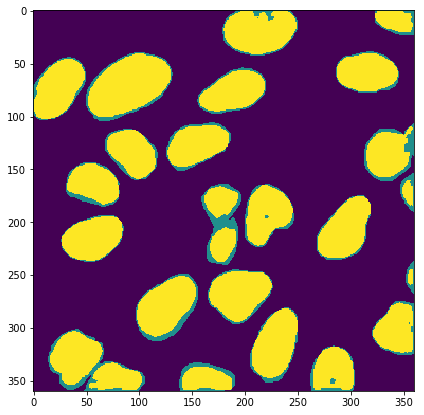

In [54]:
plt.figure(figsize=(7, 7))
plt.imshow((np.load(os.path.join(val_paths[i], 'mask.npy')) * 2 / 255) + (preds_val_upsampled[i] > .97))

In [29]:
# MIT License
# Copyright (c) 2017 Vooban Inc.
# Coded by: Guillaume Chevalier
# Source to original code and license:
#     https://github.com/Vooban/Smoothly-Blend-Image-Patches
#     https://github.com/Vooban/Smoothly-Blend-Image-Patches/blob/master/LICENSE


"""Do smooth predictions on an image from tiled prediction patches."""


import numpy as np
import scipy.signal
from tqdm import tqdm

import gc


def _spline_window(window_size, power=2):
    """
    Squared spline (power=2) window function:
    https://www.wolframalpha.com/input/?i=y%3Dx**2,+y%3D-(x-2)**2+%2B2,+y%3D(x-4)**2,+from+y+%3D+0+to+2
    """
    intersection = int(window_size/4)
    wind_outer = (abs(2*(scipy.signal.triang(window_size))) ** power)/2
    wind_outer[intersection:-intersection] = 0

    wind_inner = 1 - (abs(2*(scipy.signal.triang(window_size) - 1)) ** power)/2
    wind_inner[:intersection] = 0
    wind_inner[-intersection:] = 0

    wind = wind_inner + wind_outer
    wind = wind / np.average(wind)
    return wind


cached_2d_windows = dict()
def _window_2D(window_size, power=2):
    """
    Make a 1D window function, then infer and return a 2D window function.
    Done with an augmentation, and self multiplication with its transpose.
    Could be generalized to more dimensions.
    """
    # Memoization
    global cached_2d_windows
    key = "{}_{}".format(window_size, power)
    if key in cached_2d_windows:
        wind = cached_2d_windows[key]
    else:
        wind = _spline_window(window_size, power)
        wind = np.expand_dims(np.expand_dims(wind, 3), 3)
        wind = wind * wind.transpose(1, 0, 2)
        if PLOT_PROGRESS:
            # For demo purpose, let's look once at the window:
            plt.imshow(wind[:, :, 0], cmap="viridis")
            plt.title("2D Windowing Function for a Smooth Blending of "
                      "Overlapping Patches")
            plt.show()
        cached_2d_windows[key] = wind
    return wind


def _pad_img(img, window_size, subdivisions, PLOT_PROGRESS=False):
    """
    Add borders to img for a "valid" border pattern according to "window_size" and
    "subdivisions".
    Image is an np array of shape (x, y, nb_channels).
    """
    aug = int(round(window_size * (1 - 1.0 / subdivisions)))
    more_borders = ((aug, aug), (aug, aug), (0, 0))
    ret = np.pad(img, pad_width=more_borders, mode='reflect')
    # gc.collect()

    if PLOT_PROGRESS:
        # For demo purpose, let's look once at the window:
        plt.imshow(np.squeeze(ret))
        plt.title("Padded Image for Using Tiled Prediction Patches\n"
                  "(notice the reflection effect on the padded borders)")
        plt.show()
    return ret


def _unpad_img(padded_img, window_size, subdivisions):
    """
    Undo what's done in the `_pad_img` function.
    Image is an np array of shape (x, y, nb_channels).
    """
    aug = int(round(window_size * (1 - 1.0/subdivisions)))
    ret = padded_img[
        aug:-aug,
        aug:-aug,
        :
    ]
    # gc.collect()
    return ret


def _rotate_mirror_do(im):
    """
    Duplicate an np array (image) of shape (x, y, nb_channels) 8 times, in order
    to have all the possible rotations and mirrors of that image that fits the
    possible 90 degrees rotations.

    It is the D_4 (D4) Dihedral group:
    https://en.wikipedia.org/wiki/Dihedral_group
    """
    mirrs = []
    mirrs.append(np.array(im))
    mirrs.append(np.rot90(np.array(im), axes=(0, 1), k=1))
    mirrs.append(np.rot90(np.array(im), axes=(0, 1), k=2))
    mirrs.append(np.rot90(np.array(im), axes=(0, 1), k=3))
    im = np.array(im)[:, ::-1]
    mirrs.append(np.array(im))
    mirrs.append(np.rot90(np.array(im), axes=(0, 1), k=1))
    mirrs.append(np.rot90(np.array(im), axes=(0, 1), k=2))
    mirrs.append(np.rot90(np.array(im), axes=(0, 1), k=3))
    return mirrs


def _rotate_mirror_undo(im_mirrs):
    """
    merges a list of 8 np arrays (images) of shape (x, y, nb_channels) generated
    from the `_rotate_mirror_do` function. Each images might have changed and
    merging them implies to rotated them back in order and average things out.

    It is the D_4 (D4) Dihedral group:
    https://en.wikipedia.org/wiki/Dihedral_group
    """
    origs = []
    origs.append(np.array(im_mirrs[0]))
    origs.append(np.rot90(np.array(im_mirrs[1]), axes=(0, 1), k=3))
    origs.append(np.rot90(np.array(im_mirrs[2]), axes=(0, 1), k=2))
    origs.append(np.rot90(np.array(im_mirrs[3]), axes=(0, 1), k=1))
    origs.append(np.array(im_mirrs[4])[:, ::-1])
    origs.append(np.rot90(np.array(im_mirrs[5]), axes=(0, 1), k=3)[:, ::-1])
    origs.append(np.rot90(np.array(im_mirrs[6]), axes=(0, 1), k=2)[:, ::-1])
    origs.append(np.rot90(np.array(im_mirrs[7]), axes=(0, 1), k=1)[:, ::-1])
    return np.mean(origs, axis=0)


def _windowed_subdivs(padded_img, window_size, subdivisions, nb_classes, pred_func):
    """
    Create tiled overlapping patches.

    Returns:
        5D numpy array of shape = (
            nb_patches_along_X,
            nb_patches_along_Y,
            patches_resolution_along_X,
            patches_resolution_along_Y,
            nb_output_channels
        )

    Note:
        patches_resolution_along_X == patches_resolution_along_Y == window_size
    """
    WINDOW_SPLINE_2D = _window_2D(window_size=window_size, power=2)

    step = int(window_size / subdivisions)
    subdivs = []

    for i in range(0, padded_img.shape[0] - window_size + 1, step):
        subdivs.append([])
        for j in range(0, padded_img.shape[1] - window_size + 1, step):
            patch = padded_img[i: i + window_size, j: j + window_size, :]
            subdivs[-1].append(patch)

    # Here, `gc.collect()` clears RAM between operations.
    # It should run faster if they are removed, if enough memory is available.
    gc.collect()
    subdivs = np.array(subdivs)
    gc.collect()
    a, b, c, d, e = subdivs.shape
    subdivs = subdivs.reshape(a * b, c, d, e)
    gc.collect()

    subdivs = pred_func(subdivs)
    gc.collect()
    subdivs = np.array([patch * WINDOW_SPLINE_2D for patch in subdivs])
    gc.collect()

    # Such 5D array:
    subdivs = subdivs.reshape(a, b, c, d, nb_classes)
    gc.collect()

    return subdivs


def _recreate_from_subdivs(subdivs, window_size, subdivisions, padded_out_shape):
    """
    Merge tiled overlapping patches smoothly.
    """
    step = int(window_size / subdivisions)
    y = np.zeros(padded_out_shape)

    for a, i in enumerate(range(0, padded_out_shape[0] - window_size + 1, step)):
        for b, j in enumerate(range(0, padded_out_shape[1] - window_size + 1, step)):
            windowed_patch = subdivs[a, b]
            y[i: i + window_size, j: j + window_size] = y[i: i + window_size, j: j + window_size] + windowed_patch
    return y / (subdivisions ** 2)


def predict_img_with_smooth_windowing(input_img, window_size, subdivisions, 
                                      nb_classes, pred_func, PLOT_PROGRESS=False):
    """
    Apply the `pred_func` function to square patches of the image, and overlap
    the predictions to merge them smoothly.

    See 6th, 7th and 8th idea here:
    http://blog.kaggle.com/2017/05/09/dstl-satellite-imagery-competition-3rd-place-winners-interview-vladimir-sergey/
    """
    pad = _pad_img(input_img, window_size, subdivisions, PLOT_PROGRESS=PLOT_PROGRESS)
    pads = _rotate_mirror_do(pad)

    # Note that the implementation could be more memory-efficient by merging
    # the behavior of `_windowed_subdivs` and `_recreate_from_subdivs` into
    # one loop doing in-place assignments to the new image matrix, rather than
    # using a temporary 5D array.

    # It would also be possible to allow different (and impure) window functions
    # that might not tile well. Adding their weighting to another matrix could
    # be done to later normalize the predictions correctly by dividing the whole
    # reconstructed thing by this matrix of weightings - to normalize things
    # back from an impure windowing function that would have badly weighted
    # windows.

    # For example, since the U-net of Kaggle's DSTL satellite imagery feature
    # prediction challenge's 3rd place winners use a different window size for
    # the input and output of the neural net's patches predictions, it would be
    # possible to fake a full-size window which would in fact just have a narrow
    # non-zero dommain. This may require to augment the `subdivisions` argument
    # to 4 rather than 2.

    res = []
    for pad in tqdm(pads):
        # For every rotation:
        sd = _windowed_subdivs(pad, window_size, subdivisions, nb_classes, pred_func)
        one_padded_result = _recreate_from_subdivs(
            sd, window_size, subdivisions,
            padded_out_shape=list(pad.shape[:-1])+[nb_classes])

        res.append(one_padded_result)

    # Merge after rotations:
    padded_results = _rotate_mirror_undo(res)

    prd = _unpad_img(padded_results, window_size, subdivisions)

    prd = prd[:input_img.shape[0], :input_img.shape[1], :]

    if PLOT_PROGRESS:
        plt.imshow(np.squeeze(prd))
        plt.title("Smoothly Merged Patches that were Tiled Tighter")
        plt.show()
    return prd

# 8

In [26]:
# Load an image. Convention is channel_last, such as having an input_img.shape of: (x, y, nb_channels), where nb_channels is of 3 for regular RGB images.
def generator_test(paths, batch_size=BATCH_SIZE, train_mode=False):
    for i, path in enumerate(paths):
        patch = load(path, test_mode=True)
#         patch = np.concatenate([np.flip(patch, 0), patch, np.flip(patch, 0)])
#         patch = np.concatenate([np.flip(patch, 1), patch, np.flip(patch, 1)], 1)
        yield patch

In [27]:
MODEL_PREFIX = 'Telu32_channels3_bce1dice_unet_border1_dilated3_val_'

  0%|          | 0/10 [00:00<?, ?it/s]

0: e17b7aedd251a016c01ef9158e6e4aa940d9f1b35942d86028dc1222192a9258


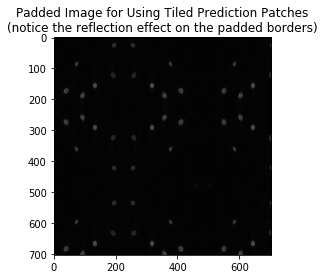


  0%|          | 0/8 [00:00<?, ?it/s]

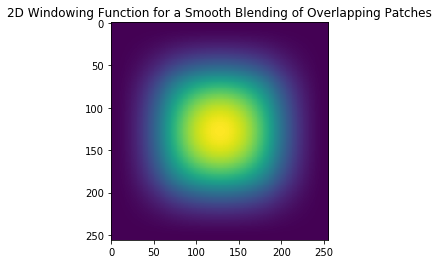

ResourceExhaustedError: OOM when allocating tensor with shape[32,256,256,32] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: conv2d_20/convolution = Conv2D[T=DT_FLOAT, data_format="NHWC", dilations=[1, 1, 1, 1], padding="SAME", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](_arg_input_2_0_1/_393, conv2d_20/kernel/read)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[Node: conv2d_39/Sigmoid/_399 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_437_conv2d_39/Sigmoid", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


Caused by op 'conv2d_20/convolution', defined at:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/race/tensorflow3.5/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/race/tensorflow3.5/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/race/tensorflow3.5/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 478, in start
    self.io_loop.start()
  File "/home/race/tensorflow3.5/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/race/tensorflow3.5/lib/python3.5/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/home/race/tensorflow3.5/lib/python3.5/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/race/tensorflow3.5/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/race/tensorflow3.5/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/race/tensorflow3.5/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/race/tensorflow3.5/lib/python3.5/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/race/tensorflow3.5/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/race/tensorflow3.5/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/race/tensorflow3.5/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/race/tensorflow3.5/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/race/tensorflow3.5/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/race/tensorflow3.5/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/race/tensorflow3.5/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2850, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/race/tensorflow3.5/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-25-ec53de79512f>", line 2, in <module>
    loss=dice_coef_loss, metrics=[binary_crossentropy, dice_coef], activation='elu')
  File "../models/UNet.py", line 26, in get_unet
    conv1 = Conv2D(filters_init, (3, 3), activation=activation, padding='same')(inputs)
  File "/home/race/tensorflow3.5/lib/python3.5/site-packages/keras/engine/topology.py", line 617, in __call__
    output = self.call(inputs, **kwargs)
  File "/home/race/tensorflow3.5/lib/python3.5/site-packages/keras/layers/convolutional.py", line 168, in call
    dilation_rate=self.dilation_rate)
  File "/home/race/tensorflow3.5/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py", line 3332, in conv2d
    data_format=tf_data_format)
  File "/home/race/tensorflow3.5/lib/python3.5/site-packages/tensorflow/python/ops/nn_ops.py", line 754, in convolution
    return op(input, filter)
  File "/home/race/tensorflow3.5/lib/python3.5/site-packages/tensorflow/python/ops/nn_ops.py", line 838, in __call__
    return self.conv_op(inp, filter)
  File "/home/race/tensorflow3.5/lib/python3.5/site-packages/tensorflow/python/ops/nn_ops.py", line 502, in __call__
    return self.call(inp, filter)
  File "/home/race/tensorflow3.5/lib/python3.5/site-packages/tensorflow/python/ops/nn_ops.py", line 190, in __call__
    name=self.name)
  File "/home/race/tensorflow3.5/lib/python3.5/site-packages/tensorflow/python/ops/gen_nn_ops.py", line 639, in conv2d
    data_format=data_format, dilations=dilations, name=name)
  File "/home/race/tensorflow3.5/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/race/tensorflow3.5/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 3160, in create_op
    op_def=op_def)
  File "/home/race/tensorflow3.5/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1625, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[32,256,256,32] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: conv2d_20/convolution = Conv2D[T=DT_FLOAT, data_format="NHWC", dilations=[1, 1, 1, 1], padding="SAME", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](_arg_input_2_0_1/_393, conv2d_20/kernel/read)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[Node: conv2d_39/Sigmoid/_399 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_437_conv2d_39/Sigmoid", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.



In [30]:
# from utils.smooth_tiled_predictions import predict_img_with_smooth_windowing
test_upsampled = list()

# Fold
for model_idx in tqdm(range(10)):
#     if model_idx == 4:
#         continue
    model.load_weights(os.path.join('..', 'data', MODEL_PREFIX + str(model_idx)))

    test_gen = generator_test(test_paths, batch_size=1, train_mode=False)
    test = [next(test_gen) for i in range(len(test_paths))]

    # Create list of upsampled test masks
    preds_test_upsampled = list()
    for i, (v_img, path) in enumerate(zip(test, test_paths)):

        PLOT_PROGRESS = False
        if model_idx == 0:
            print("%d: %s" % (i, os.path.basename(path)))
            PLOT_PROGRESS=True
            
        preds_test_upsampled.append(
            predict_img_with_smooth_windowing(
                # np.dstack([scipy.ndimage.zoom(v_img[..., channel], 1.3) for channel in range(v_img.shape[-1])]),
                v_img,
                window_size=SIDE,
                subdivisions=8,  # Minimal amount of overlap for windowing. Must be an even number.
                nb_classes=nb_classes,
                PLOT_PROGRESS=PLOT_PROGRESS,
                pred_func=(
                    lambda img_batch_subdiv: model.predict(img_batch_subdiv)
                )
            )
        )

    test_upsampled.append(preds_test_upsampled)


In [72]:
preds_test_upsampled = list()
for i in range(len(test_upsampled[0])):
    preds_test_upsampled.append(np.mean([fold[i] for fold in test_upsampled], axis=0))

In [1]:
for img, p in zip(test, preds_test_upsampled):
    plt.figure(figsize=(6, 6))
    plt.subplot(221)
    plt.imshow(np.squeeze(img))
    plt.axis('off')
    plt.subplot(222)
    plt.imshow(np.squeeze(p) > .9)
    plt.axis('off')
    plt.show()


NameError: name 'test' is not defined

In [73]:
for path, pred in zip(test_paths, preds_test_upsampled):
    np.save(os.path.join(path, 'borders_mask_Telu32_channels3_bce1dice_unet_erosion1_dilated3_zoom_x_1.3'), pred)

In [32]:
preds_test_upsampled = list()
for path in test_paths:
    im = np.load(os.path.join(path, 'borders_mask_Telu32_channels3_bce1dice_unet_erosion1_dilated3_zoom_x_1.3.npy'))
    preds_test_upsampled.append(scipy.ndimage.zoom(np.squeeze(im), 1 / 1.3))

In [33]:
new_test_ids = []
rles = []
for n, path in tqdm(enumerate(test_paths)):
    rle = list(prob_to_rles(preds_test_upsampled[n]))
    rles.extend(rle)
    new_test_ids.extend([os.path.basename(path)] * len(rle))


65it [00:01, 38.00it/s]


In [34]:
# Create submission DataFrame
sub = pd.DataFrame()
sub['ImageId'] = new_test_ids
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
sub.to_csv('../data/dsb18.csv', index=False)